### Longitudinal Dataset Tutorial

The longitudinal dataset is logically organized as a table where rows represent profiles and columns the various metrics (e.g. startup time). Each field of the table contains a list of values, one per Telemetry submission received for that profile.

The dataset is going to be regenerated from scratch every week, this allows us to apply non backward compatible changes to the schema and not worry about merging procedures. 

The current version of the longitudinal dataset has been build with all main pings received from 1% of profiles across all channels after mid November, which is shortly after Unified Telemetry landed. Future version will store up to 180 days of data.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.defaultParallelism

32

The longitudinal dataset can be accessed as a Spark [DataFrame](https://spark.apache.org/docs/1.5.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame), which is a distributed collection of data organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in R/Python.

In [3]:
frame = sqlContext.sql("SELECT * FROM longitudinal")

Number of profiles:

In [4]:
frame.count()

4101752

The dataset contains all histograms but it doesn't yet include all metrics stored in the various sections of the pings. See the [code](https://github.com/vitillo/telemetry-batch-view/blob/longitudinal/src/main/scala/streams/Longitudinal.scala#L68) that generates the dataset for a complete list of supported metrics. More metrics are going to be included in future versions of the dataset, inclusion of specific metrics can be prioritized by filing a bug.

### Scalar metrics

A Spark bug is slowing down the *first* and *take* methods on a dataframe. A way around that for now is to first convert the dataframe to a rdd and then invoke *first* or *take*, e.g.:

In [5]:
first = frame.filter("normalized_channel = 'beta'").rdd.first()

As mentioned earlier on, each field of the dataframe is an array containing one value per submission per client. The submissions are chronologically sorted.

In [6]:
len(first.build)

245

In [7]:
first.build[:5]

[Row(application_id=u'{ec8030f7-c20a-464f-9b0e-13a3a9e97384}', application_name=u'Firefox', architecture=u'x86', architectures_in_binary=None, build_id=u'20160307215824', version=u'46.0', vendor=u'Mozilla', platform_version=u'46.0', xpcom_abi=u'x86-msvc', hotfix_version=u'20160106.01'),
 Row(application_id=u'{ec8030f7-c20a-464f-9b0e-13a3a9e97384}', application_name=u'Firefox', architecture=u'x86', architectures_in_binary=None, build_id=u'20160303134406', version=u'45.0', vendor=u'Mozilla', platform_version=u'45.0', xpcom_abi=u'x86-msvc', hotfix_version=u'20160106.01'),
 Row(application_id=u'{ec8030f7-c20a-464f-9b0e-13a3a9e97384}', application_name=u'Firefox', architecture=u'x86', architectures_in_binary=None, build_id=u'20160303134406', version=u'45.0', vendor=u'Mozilla', platform_version=u'45.0', xpcom_abi=u'x86-msvc', hotfix_version=u'20160106.01'),
 Row(application_id=u'{ec8030f7-c20a-464f-9b0e-13a3a9e97384}', application_name=u'Firefox', architecture=u'x86', architectures_in_binary

Different sections of the ping are stored in different fields of the dataframe. Refer to the schema of the dataframe for a complete layout.

In [8]:
first.system[0]

Row(memory_mb=1470, virtual_max_mb=None, is_wow64=True)

Dataframes support fields that can contain structs, maps, arrays, scalars and combination thereof. Note that in the previous example the system field is an array of [Rows](https://spark.apache.org/docs/1.5.2/api/python/pyspark.sql.html#pyspark.sql.Row). You can think of a Row as a struct that allows each field to be accessed invididually. 

In [9]:
first.system[0].memory_mb

1470

### Histograms

Not all profiles have all histograms. If a certain histogram, say GC_MS, is N/A for all submissions of a profile, then the field in the DataFrame will be N/A.

In [10]:
first.gc_ms == None

False

If at least one histogram is present in the history of a profile, then all other submission that do not have that histogram will be initialized with an empty histogram.

Flag and count "histograms" are represented as scalars.

In [11]:
first.fxa_configured[:5]

[True, True, True, True, True]

Boolean histograms are represented with an array of two integers. Similarly, enumerated histograms are represented with an array of N integers.

In [12]:
first.browser_set_default_always_check[:5]

[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]

Exponential and linear histograms are represented as a struct containing an array of N integers (*values* field) and the sum of the entries (*sum* field).

In [13]:
first.browser_set_default_dialog_prompt_rawcount[:5]

[Row(values=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], sum=0),
 Row(values=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], sum=0),
 Row(values=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], sum=0),
 Row(values=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], sum=0),
 Row(values=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], sum=0)]

Keyed histograms are stored within a map from strings to values where the values depend on the histogram types and and have the same structure as mentioned above.

In [14]:
frame.select("search_counts").rdd.take(2)

[Row(search_counts={u'yahoo.urlbar': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]}),
 Row(search_counts={u'yahoo.urlbar': [0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0], u'yahoo.abouthome': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]})]

### Queries

Note that the following queries are run on a single machine and have been annotated with their run-time.

##### Project a column with [select](https://spark.apache.org/docs/1.5.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame.select):

In [15]:
%time frame.select("system").rdd.first().system[:2]

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 1.83 s


[Row(memory_mb=6092, virtual_max_mb=None, is_wow64=True),
 Row(memory_mb=6092, virtual_max_mb=None, is_wow64=True)]

###### Project a nested field:

In [16]:
%time frame.select("system.memory_mb").rdd.first()

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 1.48 s


Row(memory_mb=[6092, 6092, 6092, 6092, 6092, 6092, 6092, 6092, 6092, 6092, 6092, 6092, 6092, 6092, 6092, 6092, 6092, 6092, 6092])

###### Project a set of sql expressions with [selectExpr](https://spark.apache.org/docs/1.5.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame.selectExpr):

In [17]:
%time frame.selectExpr("size(system.memory_mb) as num_submissions").rdd.take(5)

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 1.57 s


[Row(num_submissions=19),
 Row(num_submissions=12),
 Row(num_submissions=72),
 Row(num_submissions=39),
 Row(num_submissions=245)]

In [18]:
%time frame.selectExpr("system_os.name[0] as os_name").rdd.take(5)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 2.1 s


[Row(os_name=u'Windows_NT'),
 Row(os_name=u'Darwin'),
 Row(os_name=u'Windows_NT'),
 Row(os_name=u'Windows_NT'),
 Row(os_name=u'Windows_NT')]

##### Filter profiles with where:

In [19]:
%time frame.selectExpr("system_os.name[0] as os_name").where("os_name = 'Darwin'").count()

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 1min 40s


214639

Note that metrics that don't tend to change often can be "uplifted" from their nested structure for fast selection. One of such metrics is the operating system name. More metrics can be uplifed on request.

In [20]:
%time frame.select("os").where("os = 'Darwin'").count()

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 42.9 s


214639

##### Transform to RDD

Dataframes can be transformed to RDDs that allow to easily apply user defined functions. In general it's worthwhile spending some time learning the Dataframe API as operations are optimized and run entirely in the JVM which can make queries faster.

In [21]:
rdd = frame.rdd

In [22]:
out = rdd.map(lambda x: x.search_counts).take(2)

##### Window functions

Select the earliest build-id with which a profile was seen using [window functions](https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html):

In [23]:
from pyspark.sql.window import Window
from pyspark.sql import Row
import pyspark.sql.functions as func

In [24]:
subset = frame.selectExpr("client_id", "explode(build.build_id) as build_id")

The [explode](https://spark.apache.org/docs/1.5.2/api/python/pyspark.sql.html#pyspark.sql.functions.explode) function returns a new row for each element in the given array or map. See the [documentation](https://spark.apache.org/docs/1.5.2/api/python/pyspark.sql.html#module-pyspark.sql.functions) for the complete list of functions supported by DataFrames.

In [25]:
window_spec = Window.partitionBy(subset["client_id"]).orderBy(subset["build_id"])

In [26]:
min_buildid = func.min(subset["build_id"]).over(window_spec)

In [27]:
%time subset.select("client_id", "build_id", min_buildid.alias("first_build_id")).count()

CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 4min


425396948

##### Count the number searches performed with yahoo from the urlbar

Note how individual keys can be accessed without any custom Python code.  

In [28]:
%time sensitive = frame.select("search_counts.`yahoo.urlbar`").map(lambda x: np.sum(x[0]) if x[0] else 0).sum()

CPU times: user 236 ms, sys: 92 ms, total: 328 ms
Wall time: 1min 29s


And the same operation without custom Python:

In [29]:
%time sensitive = frame.selectExpr("explode(search_counts.`yahoo.urlbar`) as searches").agg({"searches": "sum"}).collect()

CPU times: user 8 ms, sys: 8 ms, total: 16 ms
Wall time: 1min 20s


Exploding arrays seems not to be more efficient compared to custom Python code. That said, while RDD based analyses are likely not going to improve in terms of speed over time with new Spark releases, the same isn't true for DataFrame based ones.

##### Aggregate GC_MS histograms for all users with extended Telemetry enabled

In [30]:
%%time

def sum_array(x, y):    
    tmp = [0]*len(x)
    for i in range(len(x)):
        tmp[i] = x[i] + y[i]
    return tmp

histogram = frame.select("GC_MS", "settings.telemetry_enabled")\
    .where("telemetry_enabled[0] = True")\
    .flatMap(lambda x: [v.values for v in x.GC_MS] if x.GC_MS else [])\
    .reduce(lambda x, y: sum_array(x, y))

histogram

CPU times: user 228 ms, sys: 80 ms, total: 308 ms
Wall time: 3min 37s


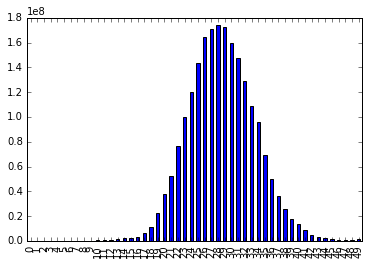

In [31]:
pd.Series(histogram).plot(kind="bar")

### Schema

In [32]:
frame.printSchema()

root
 |-- client_id: string (nullable = true)
 |-- os: string (nullable = true)
 |-- normalized_channel: string (nullable = true)
 |-- submission_date: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sample_id: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- size: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- geo_country: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- geo_city: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- dnt_header: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- addons: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- async_plugin_init: array (nullable = true)
 |    |-- element: boolean (containsNull = true)
 |-- flash_version: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- previous_build_id: array (nullable = true)
 |    |-- element